# Temperature and metallic systems

In this example we consider the modeling of a magnesium lattice
as a simple example for a metallic system.
For our treatment we will use the PBE exchange-correlation functional.
First we import required packages and setup the lattice.
Again notice that DFTK uses the convention that lattice vectors are
specified column by column.

In [1]:
using DFTK
using Plots
using Unitful
using UnitfulAtomic

a = 3.01794  # bohr
b = 5.22722  # bohr
c = 9.77362  # bohr
lattice = [[-a -a  0]; [-b  b  0]; [0   0 -c]]
Mg = ElementPsp(:Mg, psp=load_psp("hgh/pbe/Mg-q2"))
atoms = [Mg => [[2/3, 1/3, 1/4], [1/3, 2/3, 3/4]]];

Next we build the PBE model and discretize it.
Since magnesium is a metal we apply a small smearing
temperature to ease convergence using the Fermi-Dirac
smearing scheme. Note that both the `Ecut` is too small
as well as the minimal ``k``-point spacing
`kspacing` far too large to give a converged result.
These have been selected to obtain a fast execution time.
By default `PlaneWaveBasis` chooses a `kspacing`
of `2π * 0.022` inverse Bohrs, which is much more reasonable.

In [2]:
kspacing = 0.945 / u"angstrom"  # Minimal spacing of k-points,
#                                in units of wavevectors (inverse Bohrs)
Ecut = 5                        # kinetic energy cutoff in Hartree
temperature = 0.01              # Smearing temperature in Hartree

model = model_DFT(lattice, atoms, [:gga_x_pbe, :gga_c_pbe];
                  temperature=temperature,
                  smearing=DFTK.Smearing.FermiDirac())
kgrid = kgrid_size_from_minimal_spacing(lattice, kspacing)
basis = PlaneWaveBasis(model, Ecut, kgrid=kgrid);

Finally we run the SCF. Two magnesium atoms in
our pseudopotential model result in four valence electrons being explicitly
treated. Nevertheless this SCF will solve for eight bands by default
in order to capture partial occupations beyond the Fermi level due to
the employed smearing scheme. In this example we use a damping of `0.8`
and Kerker mixing to ease convergence.

In [3]:
scfres = self_consistent_field(basis, α=0.8, mixing=KerkerMixing());

n     Free energy       Eₙ-Eₙ₋₁     ρout-ρin   Diag
---   ---------------   ---------   --------   ----
  1   -1.761868626545         NaN   5.04e-02    4.7 
  2   -1.762137597998   -2.69e-04   1.90e-02    1.0 
  3   -1.762239608150   -1.02e-04   1.55e-03    3.7 
  4   -1.762241595477   -1.99e-06   3.26e-04    2.7 
  5   -1.762241619868   -2.44e-08   1.74e-05    2.7 


In [4]:
scfres.occupation[1]

9-element Vector{Float64}:
 1.9999999999077946
 1.9999975862944301
 0.00401692013260586
 3.0005347434856038e-15
 1.111497112735976e-18
 1.1114280912786433e-18
 7.978816718411586e-19
 7.978168856091271e-19
 3.257106327768708e-22

In [5]:
scfres.energies

Energy breakdown:
    Kinetic             0.7180594 
    AtomicLocal         0.3145400 
    AtomicNonlocal      0.3265797 
    Ewald               -2.1544222
    PspCorrection       -0.1026056
    Hartree             0.0055002 
    Xc                  -0.8610486
    Entropy             -0.0088446

    total               -1.762241619868


The fact that magnesium is a metal is confirmed
by plotting the density of states around the Fermi level.

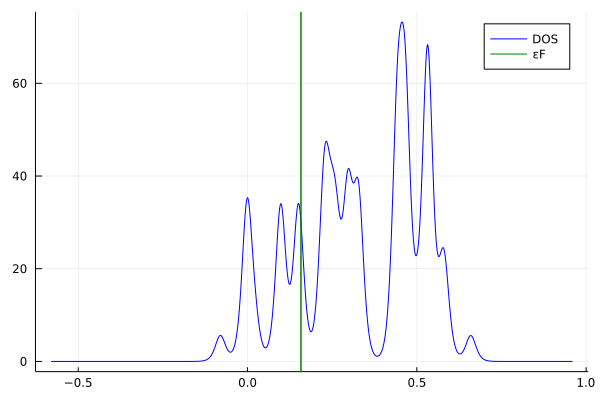

In [6]:
plot_dos(scfres)